In [29]:
%run script/prep.py

from numpy.linalg import inv

In [30]:
from datetime import date

# definitions

In [31]:
def sa_res(y):
    y_na = y.dropna().copy()
    y_mean = y_na.mean()
    mdum = pd.DataFrame(index=y_na.index)

    for i in range(12):
        mdum[i] = (mdum.index.month==i+1) * 1

    res = y_na - mdum.dot(inv(mdum.T.dot(mdum))).dot(mdum.T).dot(y_na)
    res = res + y_mean
    res = res.reindex(y.index)
    
    return res

# IMPORT

## Timeseries Data

In [32]:
data = pd.read_excel('input\\nowcasting - Timeseries Data.xlsx', sheet_name='nowcasting - Timeseries Data', 
                   header=None, index_col=0)

data.columns = [data.iloc[0], data.iloc[1]]
data = data.iloc[3:, :]
data1 = data.loc[data.index.intersection(pd.date_range('2001-1-1', '2025-3-1', freq='MS'))]
data2 = data.loc[data.index.intersection(pd.date_range('2001-1-1', '2025-3-1', freq='MS') + MonthEnd())]
data1.index = data1.index + MonthEnd()
data = pd.concat([data1.dropna(how='all', axis=1), data2.dropna(how='all', axis=1)], axis = 1)
data0 = data.astype(float)

data = pd.read_excel('input\\now - Timeseries Data.xlsx', sheet_name='now - Timeseries Data', 
                   header=None, index_col=0)

data.columns = [data.iloc[0], data.iloc[1]]
data = data.iloc[3:, :]
data1 = data.loc[data.index.intersection(pd.date_range('2001-1-1', '2025-3-1', freq='MS'))]
data2 = data.loc[data.index.intersection(pd.date_range('2001-1-1', '2025-3-1', freq='MS') + MonthEnd())]
data1.index = data1.index + MonthEnd()
data = pd.concat([data1.dropna(how='all', axis=1), data2.dropna(how='all', axis=1)], axis = 1)
data1 = data.astype(float)

data = pd.concat([data0, data1], axis=1)
data.columns = data.columns.droplevel(level=0)

# 값이 같은 열을 모두 제거, ecos, kosis 소비자물가지수가 동일하여, ecos 지수가 제거됨
kosis_price = ['KOSIS-101_DT_1J17001-M-T-T10-0-14691_BSM00033']
data = data.drop(kosis_price, axis=1)

data = data.T.drop_duplicates().T

## Meta Data

In [33]:
meta0 = pd.read_excel('input\\nowcasting - Meta Data.xlsx', sheet_name='nowcasting - Meta Data', header=0, index_col=[0, 1])
meta1 = pd.read_excel('input\\now - Meta Data.xlsx', sheet_name='now - Meta Data', header=0, index_col=[0, 1])
meta = pd.concat([meta0, meta1], axis=0)

# 모형 포함 여부, 블록 1/2/3/4, 변환 방식, 변수 카테고리, 계절성 여부(자의적 판단)
columns = ['ID', 'Model', 'Block1-Global', 'Block2-Soft', 'Block3-Real', 'Block4-Labor', 'Transformation', 'Category', 'sa']

# 변수 spec

## Labor

In [34]:
labor = ['L_em', 'L_ur', 'L_er', 'L_ml', 'L_mr']

### 취업자수
meta.loc['KOSIS-101_DT_1DA9001S-M-T30-00-14STD06156', columns] = ['L_em', 1, 1, 0, 0, 1, 'pch', 'labor', 0]
### 실업률
meta.loc['KOSIS-101_DT_1DA9001S-M-T80-00-14STD00018', columns] = ['L_ur', 1, 1, 0, 0, 1, 'chg', 'Labor', 0]
### 고용률
meta.loc['KOSIS-101_DT_1DA7001S-M-T90-0-14STD00018', columns] = ['L_er', 1, 1, 0, 0, 1, 'chg', 'Labor', 1]
### 구직배수
meta.loc['ENARA-JOBSEEK-T03-%-M', columns] = ['L_ml', 1, 1, 0, 0, 1, 'chg', 'Labor', 1]
### 취업률
meta.loc['ENARA-JOBSEEK-T05-%-M', columns] = ['L_mr', 1, 1, 0, 0, 1, 'chg', 'Labor', 1]

## National Accounts

In [35]:
na = ['N_gdp', 'N_pc', 'N_fi', 'N_ci', 'N_gx']
### 국내총생산 증가율, 실질, 전기대비
meta.loc['ECOS-111U055-10111-QQ', columns] = ['N_gdp', 1, 1, 0, 1, 0, 'raw', 'National Accounts', 0]
### 민간소비 증가율, 실질, 전기대비
meta.loc['ECOS-111U055-10122-QQ', columns] = ['N_pc', 1, 1, 0, 1, 0, 'raw', 'National Accounts', 0]
### 설비투자 증가율, 실질, 전기대비
meta.loc['ECOS-111U055-10123-QQ', columns] = ['N_fi', 1, 1, 0, 1, 0, 'raw', 'National Accounts', 0]
### 건설투자 증가율, 실질, 전기대비
meta.loc['ECOS-111U055-10124-QQ', columns] = ['N_ci', 1, 1, 0, 1, 0, 'raw', 'National Accounts', 0]
### 재화수출 증가율, 실질, 전기대비
meta.loc['ECOS-111U055-10125-QQ', columns] = ['N_gx', 1, 1, 0, 1, 0, 'raw', 'National Accounts', 0]

## Prices

In [36]:
price = ['P_cpi', 'P_ppi', 'P_core1', 'P_core2']
### CPI
meta.loc['ECOS-021U125-MM-0', columns] = ['P_cpi', 1, 1, 0, 0, 0, 'pch', 'Prices', 0]
### 생산자 물가지수
meta.loc['ECOS-013U202-MM-*AA', columns] = ['P_ppi', 1, 1, 0, 0, 0, 'pch', 'Prices', 0]
### 농산물 석유, 식료품 에너지 제외 지수
meta.loc['KOSIS-101_DT_1J17007-M-T10-QB-14691_BSM00033', columns] = ['P_core1', 1, 1, 0, 0, 0, 'pch', 'Prices', 0]
meta.loc['KOSIS-101_DT_1J17009-M-T10-DB-14691_BSM00033', columns] = ['P_core2', 1, 1, 0, 0, 0, 'pch', 'Prices', 0]

## 생산 재고 출하

In [37]:
mfg = ['M_p', 'M_i', 'M_ic', 'M_ii', 'M_if', 'M_s', 'M_sc', 'M_si', 'M_sf', 'M_ur', 'M_fi', 'P_s', 'P_m', 'P_c']

### 제조업 생산지수
meta.loc['KOSIS-101_DT_1F01501-M-T20-00-C-14691_BSM00033', columns] = ['M_p', 1, 1, 0, 1, 0, 'pch', 'Manufacturing', 0]
### 제조업 재고지수
meta.loc['KOSIS-101_DT_1F01501-M-T22-00-C-14691_BSM00033', columns] = ['M_i', 1, 1, 0, 1, 0, 'pch', 'Manufacturing', 0]
### 제조업 재고지수, 자본재, 중간재, 소비재
meta.loc['KOSIS-101_DT_1F01503-M-T22-00-1-14691_BSM00033', columns] = ['M_ic', 1, 1, 0, 1, 0, 'pch', 'Manufacturing', 0]
meta.loc['KOSIS-101_DT_1F01503-M-T22-00-2-14691_BSM00033', columns] = ['M_ii', 1, 1, 0, 1, 0, 'pch', 'Manufacturing', 0]
meta.loc['KOSIS-101_DT_1F01503-M-T22-00-3-14691_BSM00033', columns] = ['M_if', 1, 1, 0, 1, 0, 'pch', 'Manufacturing', 0]
### 제조업 출하지수
meta.loc['KOSIS-101_DT_1F01501-M-T21-00-C-14691_BSM00033', columns] = ['M_s', 1, 1, 0, 1, 0, 'pch', 'Manufacturing', 0]
### 제조업 출하지수, 자본재, 중간재, 소비재
meta.loc['KOSIS-101_DT_1F01503-M-T21-00-1-14691_BSM00033', columns] = ['M_sc', 1, 1, 0, 1, 0, 'pch', 'Manufacturing', 0]
meta.loc['KOSIS-101_DT_1F01503-M-T21-00-2-14691_BSM00033', columns] = ['M_si', 1, 1, 0, 1, 0, 'pch', 'Manufacturing', 0]
meta.loc['KOSIS-101_DT_1F01503-M-T21-00-3-14691_BSM00033', columns] = ['M_sf', 1, 1, 0, 1, 0, 'pch', 'Manufacturing', 0]
### 제조업 가동률 지수
meta.loc['KOSIS-101_DT_1F31501-M-T30-C-14691_BSM00033', columns] = ['M_ur', 1, 1, 0, 1, 0, 'chg', 'Manufacturing', 0]
### 설비투자 지수
meta.loc['KOSIS-101_DT_1F70011-M-T5-C-14691_BSM00033', columns] = ['M_fi', 1, 1, 0, 1, 0, 'chg', 'Manufacturing', 0]
### 전산업생산지수 서비스업, 광공업, 건설업
meta.loc['KOSIS-101_DT_1JH20152-M-T1-1C-14691_BSM00033', columns] = ['I_s', 1, 1, 0, 1, 0, 'pch', 'Manufacturing', 0]
meta.loc['KOSIS-101_DT_1JH20152-M-T1-1B-14691_BSM00033', columns] = ['I_m', 1, 1, 0, 1, 0, 'pch', 'Manufacturing', 0]
meta.loc['KOSIS-101_DT_1JH20152-M-T1-1D-14691_BSM00033', columns] = ['I_c', 1, 1, 0, 1, 0, 'pch', 'Manufacturing', 0]

## 소매 및 소비

In [38]:
retail = ['R_s', 'R_d']
### 소매 판매액 지수
meta.loc['KOSIS-101_DT_1K31012-M-T3-G0-14691_BSM00033', columns] = ['R_s', 1, 1, 0, 1, 0, 'pch', 'Retail and Consumption', 0]

### 내구재 판매액지수
meta.loc['KOSIS-101_DT_1K31012-M-T3-G1-14691_BSM00033', columns] = ['R_d', 1, 1, 0, 1, 0, 'pch', 'Manufacturing', 0]

## 주택 및 건설

In [39]:
house = ['H_s', 'H_c', 'H_p']
### 주택착공실적 --------------- 2011년 이후 가용하므로 모델에서 제외
meta.loc['KOSIS-116_DT_MLTM_5386-M-13103766971T1-13102766971A_0001-13102766971B_0001-13102766971C_0001-14STD06712', 
         columns] = ['H_s', 0, 1, 0, 1, 0, 'pch', 'Housing and Construction', 0]

### 건설기성액
meta.loc['KOSIS-101_DT_1G18012-M-T1-0-14STD05057', columns] = ['H_c', 1, 1, 0, 1, 0, 'pch', 'Housing and Construction', 0]

### 주택건설 인허가실적
meta.loc['MOLIT-HOUSE_PERMIT-KR_00-T1-UT-M', columns] = ['H_p', 1, 1, 0, 1, 0, 'chg', 'Housing and Construction', 1]

## International Trade

In [40]:
trade = ['B_gi', 'B_sx', 'B_gx', 'B_si', 'B_bx', 'B_bi', 'B_pi', 'B_px']
### 수출입
meta.loc['ECOS-022U113-MM-SA120', columns] = ['B_gi', 1, 1, 0, 1, 0, 'pch', 'International Trade', 0] # 상품수입
meta.loc['ECOS-022U113-MM-SA210', columns] = ['B_sx', 1, 1, 0, 1, 0, 'pch', 'International Trade', 0] # 서비스수입
meta.loc['ECOS-022U113-MM-SA110', columns] = ['B_gx', 1, 1, 0, 1, 0, 'pch', 'International Trade', 0] # 상품수출
meta.loc['ECOS-022U113-MM-SA220', columns] = ['B_si', 1, 1, 0, 1, 0, 'pch', 'International Trade', 0] # 서비스지급

### bloomberg
meta.loc['BBG-BBG-KOEXTOT_Index', columns] = ['B_bx', 1, 1, 0, 1, 0, 'pch', 'International Trade', 0] # export
meta.loc['BBG-BBG-KOIMTOT_Index', columns] = ['B_bi', 1, 1, 0, 1, 0, 'pch', 'International Trade', 0] # import

### 수입물가지수, 수출물가지수
meta.loc['ECOS-018U301-MM-*AA-W', columns] = ['B_pi', 1, 1, 0, 1, 0, 'pch', 'International Trade', 0]
meta.loc['ECOS-019U301-MM-*AA-W', columns] = ['B_px', 1, 1, 0, 1, 0, 'pch', 'International Trade', 0]

### 서베이

In [41]:
survey = ['S_cs', 'S_cb', 'S_es', 'S_as', 'S_ab', 'S_mo', 'S_mf', 'S_mu', 'S_mb', 'S_mx', 'S_md']
### 소비자동향조사, 소비자심리지수   ## 2008년 이후... 일단 포함!!
meta.loc['KOSIS-301_DT_040Y002-M-13103112548999-13102112548CSI_CODE_FME-13102112548CSI_PART_99988',    
         columns] = ['S_cs', 1, 1, 1, 0, 0, 'chg', 'Surveys', 0]
### 소비자동향조사, 현재경기판단CSI
meta.loc['KOSIS-301_DT_040Y002-M-13103112548999-13102112548CSI_CODE_FMAB-13102112548CSI_PART_99988', 
         columns] = ['S_cb', 1, 1, 1, 0, 0, 'chg', 'Surveys', 0]
### 경제심리지수, 순환변동치
meta.loc['ECOS-042U001-MM-E2000', columns] = ['S_es', 1, 1, 1, 0, 0, 'raw', 'Surveys', 0]

### 기업경기실사지수
### 전산업 매출 실적
meta.loc['ECOS-041U013-MM-99988-AB', columns] = ['S_as', 1, 1, 1, 0, 0, 'chg', 'Surveys', 0]
### 전산업 업황 실적
meta.loc['ECOS-041U013-MM-99988-AA', columns] = ['S_ab', 1, 1, 1, 0, 0, 'chg', 'Surveys', 0]
### 제조업 신규수주 실적
meta.loc['ECOS-041U013-MM-C0000-AD', columns] = ['S_mo', 1, 1, 1, 0, 0, 'chg', 'Surveys', 0]
### 제조업 설비투자 실적
meta.loc['ECOS-041U013-MM-C0000-AI', columns] = ['S_mf', 1, 1, 1, 0, 0, 'chg', 'Surveys', 0]
### 제조업 가동률 실적
meta.loc['ECOS-041U013-MM-C0000-AK', columns] = ['S_mu', 1, 1, 1, 0, 0, 'chg', 'Surveys', 0]
### 제조업 업황 실적
meta.loc['ECOS-041U013-MM-C0000-AS', columns] = ['S_mb', 1, 1, 1, 0, 0, 'chg', 'Surveys', 0]
### 제조업 수출 실적
meta.loc['ECOS-041U013-MM-C0000-AM', columns] = ['S_mx', 1, 1, 1, 0, 0, 'chg', 'Surveys', 0]
### 제조업 내수판매 실적
meta.loc['ECOS-041U013-MM-C0000-AL', columns] = ['S_md', 1, 1, 1, 0, 0, 'chg', 'Surveys', 0]

In [42]:
total = survey + trade + house + retail + mfg + price + na + labor

## Select Timeseries Data

In [43]:
meta = meta.loc[meta.Model.eq(1), :].drop_duplicates()
ids = meta.reset_index().set_index('Series ID')[['ID']]
mdata = pd.concat([data.T, meta.reset_index().set_index('Series ID')[['ID']]], axis=1)
mdata = mdata.set_index('ID', append=True)
mdata.index.names = ['Series ID', 'ID']
mdata = mdata.T
mdata.columns = mdata.columns.droplevel(level=0)
mdata = mdata[ids.ID.tolist()]
mdata.index = pd.to_datetime(mdata.index)
mdata = mdata.loc['2000':, :]

mdata = pd.concat([mdata.loc[:, ~mdata.columns.isin(na)], mdata[na].shift(2).dropna()], axis=1)

mdata.index = pd.to_datetime(mdata.index)
mdata.index.freq = 'M'

# Save meta to Spec.xlsx

In [44]:
meta['SeriesName'] = meta.ID
Spec = meta.reset_index()[['Model', 'ID', 'SeriesName', 'Frequency', 'Block1-Global', 'Block2-Soft', 'Block3-Real', 'Block4-Labor', 'Transformation', 'Unit', 'Category']]
Spec = Spec.rename(columns={'ID':'SeriesID', 'Unit':'Units'})
Spec = Spec.replace({'월':'m', '분기':'q'})
for v in ['Model', 'Block1-Global', 'Block2-Soft', 'Block3-Real', 'Block4-Labor']:
    Spec[v] = Spec[v].astype(int)
Spec.to_excel('input\\Spec.xlsx', index=False)

# 빈티지 데이터셋 만들기

- 과거 빈티지별 데이터셋은 변수별로 처음 데이터가 입수된 이후 revision이 없다고 가정
    - 변수별로 가장 작은 delay(입수날짜-해당월말일)를 파악한 다음, 각 빈티지에 대해 (xx월 말일-delay)가 빈티지 날짜를 앞설 경우 동 변수의 xx월 값을 빈티지 데이터셋에 포함
    
- 최소 10년간 데이터를 이용하여 추정하되, 2003년 이후 입수하기 시작한 데이터가 많으므로 2013년 이후부터 빈티지 데이터 셋 생성

In [45]:
hist1 = pd.read_csv('input\\이현창반장님_20210315_final.csv', low_memory=False)
hist2 = pd.read_csv('input\\이현창반장님_20210317_final.csv', low_memory=False)
hist = pd.concat([hist1, hist2], axis=0).drop_duplicates()
df0 = meta.reset_index()[['Series ID', 'ID']]
hist = hist.merge(df0, left_on='S_ID', right_on='Series ID')
histQ = hist.loc[hist.ID.isin(na)].copy()
histM = hist.loc[~hist.ID.isin(na)].copy()
histQ.PERIOD = pd.to_datetime(histQ.PERIOD) + QuarterEnd()
histM.loc[histM.PERIOD.str.len()==6, 'Day'] = '01'
histM.loc[histM.PERIOD.str.len()==6, 'PERIOD'] = pd.to_datetime(histM.loc[histM.PERIOD.str.len()==6, 'PERIOD'] + histM.loc[histM.PERIOD.str.len()==6, 'Day']) + MonthEnd()
# histM.loc[histM.PERIOD.str.len()==8, 'PERIOD'] = pd.to_datetime(histM.loc[histM.PERIOD.str.len()==8, 'PERIOD'])
histM.PERIOD = pd.to_datetime(histM.PERIOD)
histM = histM.drop('Day', axis=1)
hist = pd.concat([histM, histQ], axis=0)
hist.REG_D = pd.to_datetime(hist.REG_D.astype(str))
hist.END_D = pd.to_datetime(hist.END_D.astype(str).replace({'9999':'2100'}, regex=True))

# hist.REG_D.min()
# Timestamp('2019-03-14 00:00:00')

hist = hist.loc[hist.PERIOD.ge('2020-1-1')]
hist['delay'] = hist.REG_D - hist.PERIOD
hist = hist.rename(columns={'DATA_VALUE':'VALUE'})
hist = hist.set_index(['ID', 'PERIOD'])[['REG_D', 'END_D', 'delay', 'VALUE']].sort_index(axis=0)

hist['nrevision_period'] = hist.groupby(level=[0, 1], axis=0)['delay'].count()
delay_id = hist.groupby(level=[0], axis=0)['delay'].min()

In [48]:
vintages = pd.date_range(date(2013, 1, 4), date(2021, 4, 30), freq='7D')
# vintages = pd.date_range(date(2019, 1, 4), date(2021, 4, 30), freq='7D')
print('from {:} to {:}'.format(vintages[0].strftime('%Y-%m-%d %A'), vintages[-1].strftime('%Y-%m-%d %A')))

month_ends = pd.date_range(mdata.index[0], mdata.index[-1], freq='M')

hval = hist.reset_index()[['ID', 'PERIOD', 'REG_D', 'VALUE']].sort_values(['ID', 'PERIOD', 'REG_D'])
hval['VALUE'] = hval['VALUE'].astype(float)

for t in vintages:
    dataset = pd.DataFrame()
    for j in mdata.columns:
        # 최초 공표일이 빈티지보다 빠른 가장 최근 월
        up_to_date = mdata.loc[month_ends[month_ends.date + delay_id[j] <= t], [j]]

        for t1 in pd.date_range('2019-1-1', up_to_date.index[-1], freq='M'):
            try:
                temp = float(hval.loc[hval.ID.eq(j) & hval.PERIOD.eq(t1) & hval.REG_D.le(t)].iloc[-1, -1])
                if up_to_date.loc[t1, j] != temp:
#                     print('temp value used', j, t1.date(), t.date(), up_to_date.loc[t1, j], '->', temp)
                    up_to_date.loc[t1, j] = temp                    
            except:
                continue
                
        dataset = pd.concat([dataset, up_to_date], axis = 1)
    dataset.index = dataset.index.strftime("%Y-%m-%d")
    dataset.to_excel('input\\mdata\\' + t.date().strftime('%Y-%m-%d') + '.xlsx', sheet_name='data')

from 2013-01-04 Friday to 2021-04-30 Friday


<AxesSubplot:xlabel='ID'>

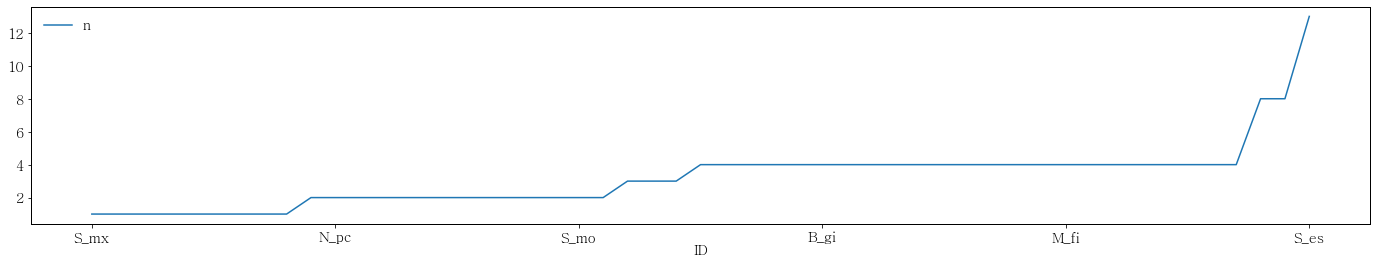

In [62]:
nrevision_id = hist.groupby(level=[0], axis=0)['nrevision_period'].max()

nrevision_id.to_frame('n').sort_values('n').plot(figsize=(24, 4))